In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,auc,roc_auc_score
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
df = pd.read_csv('creditcard.csv')
print(df.shape)

(284807, 31)


In [ ]:
from sklearn.preprocessing import StandardScaler
df['scaled_Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df = df.drop(['Amount'],axis=1)
# The 'Amount' feature is on a different scale compared to the other principal components(V1~V28),
# so it will be standardized using StandardScaler and stored in the dataframe for later use.

In [ ]:
def split_data(df, drop_list):
    df = df.drop(drop_list,axis=1)
    #test train split time
    from sklearn.model_selection import train_test_split
    y = df['Class'].values #target
    X = df.drop(['Class'],axis=1).values #features
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

    print("train-set size: ", len(y_train),
      "\ntest-set size: ", len(y_test))
    print("fraud cases in test-set: ", sum(y_test))
    return X_train, X_test, y_train, y_test
print(df.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class',
       'scaled_Amount'],
      dtype='object')


In [ ]:
def get_predictions(clf, X_train, y_train, X_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)
    train_pred = clf.predict(X_train)
    print('train-set confusion matrix:\n', confusion_matrix(y_train,train_pred))
    return y_pred, y_pred_prob

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
drop_list = []
X_train, X_test, y_train, y_test = split_data(df, drop_list)
model = GaussianNB()
y_pred, y_pred_prob = get_predictions(model, X_train, y_train, X_test)

feature_names1 = df.drop(drop_list + ['Class'], axis=1).columns
theta_df1 = pd.DataFrame(model.theta_, columns=feature_names1)
theta_df1.index = [f'class {i}' for i in model.classes_]
var_df1 = pd.DataFrame(model.var_, columns=feature_names1)
var_df1.index = [f'class {i}' for i in model.classes_]

print("📌 변수 별 변수 평균 (theta_):")
print(theta_df1)
print("\n📌 변수 별 변수 분산 (var_):")
print(var_df1)

train-set size:  227845 
test-set size:  56962
fraud cases in test-set:  98
train-set confusion matrix:
 [[225999   1452]
 [   140    254]]
📌 변수 별 변수 평균 (theta_):
                 Time        V1        V2        V3        V4        V5  \
class 0  94905.972262  0.008952 -0.006698  0.011860 -0.007976  0.005548   
class 1  82832.177665 -4.707808  3.588729 -7.068378  4.592975 -3.101629   

               V6        V7        V8        V9  ...       V20       V21  \
class 0  0.001230  0.009673 -0.001453  0.005189  ... -0.001621 -0.000719   
class 1 -1.387192 -5.539909  0.587920 -2.589654  ...  0.358018  0.628814   

              V22       V23       V24       V25       V26       V27       V28  \
class 0  0.000214  0.000159 -0.000089 -0.000690  0.000043 -0.000341  0.000020   
class 1  0.051318 -0.062790 -0.109108  0.019602  0.047827  0.155933  0.077212   

         scaled_Amount  
class 0      -0.000952  
class 1       0.148896  

[2 rows x 30 columns]

📌 변수 별 변수 분산 (var_):
                 T

In [ ]:
v_features = [f'V{i}' for i in range(1, 29)]

mean_0 = theta_df1.loc['class 0', v_features].values
mean_1 = theta_df1.loc['class 1', v_features].values
var_0 = var_df1.loc['class 0', v_features].values
var_1 = var_df1.loc['class 1', v_features].values

separation_scores = np.abs(mean_1 - mean_0) / np.sqrt(var_1 + var_0)

importance_df = pd.DataFrame({
    'Feature': v_features,
    'Separation Score': separation_scores
}).sort_values(by='Separation Score', ascending=False).reset_index(drop=True)


print("\n📌 Naive Bayes Separation Score (by Variable):")
for idx, row in importance_df.iterrows():
    print(f"{row['Feature']}: {row['Separation Score']:.5f}")
#Set the threshold to 0.4 and exclude all features with a score below that


📌 Naive Bayes Separation Score (by Variable):
V14: 1.42405
V4: 1.19755
V12: 1.18648
V11: 1.04583
V10: 1.03788
V3: 0.93078
V16: 0.90953
V17: 0.89894
V9: 0.75201
V7: 0.72067
V2: 0.70917
V1: 0.63647
V18: 0.59577
V5: 0.52145
V6: 0.44477
V19: 0.23128
V21: 0.14421
V20: 0.13581
V8: 0.08308
V27: 0.06123
V13: 0.05417
V15: 0.04935
V24: 0.04811
V28: 0.03479
V23: 0.02266
V26: 0.02146
V22: 0.01911
V25: 0.00868


In [ ]:
# Case-1 : do not drop anything
drop_list = []
X_train, X_test, y_train, y_test = split_data(df, drop_list)
model = GaussianNB()
y_pred, y_pred_prob = get_predictions(model, X_train, y_train, X_test)
a1=confusion_matrix(y_test,y_pred)
a2=recall_score(y_test,y_pred)
a3=precision_score(y_test,y_pred)
a4=f1_score(y_test,y_pred)
a5=accuracy_score(y_test,y_pred)
print('test-set confusion matrix:\n', a1)
print("recall score: ", a2)
print("precision score: ", a3)
print("f1 score: ", a4)
print("accuracy score: ", a5)
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob[:,1]))

train-set size:  227845 
test-set size:  56962
fraud cases in test-set:  98
train-set confusion matrix:
 [[225999   1452]
 [   140    254]]
test-set confusion matrix:
 [[56473   391]
 [   33    65]]
recall score:  0.6632653061224489
precision score:  0.1425438596491228
f1 score:  0.23465703971119134
accuracy score:  0.992556441136196
ROC AUC: 0.9679048937385871


In [ ]:
# Case-2 : drop # Case-NB-2 : drop V19,V21,V20,V8,V27,V13,V15,V24,V28,V23,V26,V22,V25
drop_list = ['V19','V21','V20','V8','V27','V13','V15','V24','V28','V23','V26','V22','V25']
X_train, X_test, y_train, y_test = split_data(df, drop_list)
model = GaussianNB()
y_pred, y_pred_prob = get_predictions(model, X_train, y_train, X_test)
b1=confusion_matrix(y_test,y_pred)
b2=recall_score(y_test,y_pred)
b3=precision_score(y_test,y_pred)
b4=f1_score(y_test,y_pred)
b5=accuracy_score(y_test,y_pred)
print('test-set confusion matrix:\n', b1)
print("recall score: ", b2)
print("precision score: ", b3)
print("f1 score: ", b4)
print("accuracy score: ", b5)
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob[:,1]))

train-set size:  227845 
test-set size:  56962
fraud cases in test-set:  98
train-set confusion matrix:
 [[226331   1120]
 [   135    259]]
test-set confusion matrix:
 [[56543   321]
 [   31    67]]
recall score:  0.6836734693877551
precision score:  0.17268041237113402
f1 score:  0.2757201646090535
accuracy score:  0.9938204416979741
ROC AUC: 0.9658908688686504


In [ ]:
# Case-3 : drop some of principle components + Time
drop_list = ['Time','V19','V21','V20','V8','V27','V13','V15','V24','V28','V23','V26','V22','V25']
X_train, X_test, y_train, y_test = split_data(df, drop_list)
model = GaussianNB()
y_pred, y_pred_prob = get_predictions(model, X_train, y_train, X_test)
c1=confusion_matrix(y_test,y_pred)
c2=recall_score(y_test,y_pred)
c3=precision_score(y_test,y_pred)
c4=f1_score(y_test,y_pred)
c5=accuracy_score(y_test,y_pred)
print('test-set confusion matrix:\n', c1)
print("recall score: ", c2)
print("precision score: ", c3)
print("f1 score: ", c4)
print("accuracy score: ", c5)
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob[:,1]))

train-set size:  227845 
test-set size:  56962
fraud cases in test-set:  98
train-set confusion matrix:
 [[224452   2999]
 [    62    332]]
test-set confusion matrix:
 [[56054   810]
 [   12    86]]
recall score:  0.8775510204081632
precision score:  0.09598214285714286
f1 score:  0.17303822937625754
accuracy score:  0.9855693269197009
ROC AUC: 0.9580382624349684


In [ ]:
# Case-4 : drop some of principle components + 'scaled_Amount'
drop_list = ['scaled_Amount','V19','V21','V20','V8','V27','V13','V15','V24','V28','V23','V26','V22','V25']
X_train, X_test, y_train, y_test = split_data(df, drop_list)
model = GaussianNB()
y_pred, y_pred_prob = get_predictions(model, X_train, y_train, X_test)
d1=confusion_matrix(y_test,y_pred)
d2=recall_score(y_test,y_pred)
d3=precision_score(y_test,y_pred)
d4=f1_score(y_test,y_pred)
d5=accuracy_score(y_test,y_pred)
print('test-set confusion matrix:\n', d1)
print("recall score: ", d2)
print("precision score: ", d3)
print("f1 score: ", d4)
print("accuracy score: ", d5)
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob[:,1]))

train-set size:  227845 
test-set size:  56962
fraud cases in test-set:  98
train-set confusion matrix:
 [[226339   1112]
 [   135    259]]
test-set confusion matrix:
 [[56546   318]
 [   32    66]]
recall score:  0.673469387755102
precision score:  0.171875
f1 score:  0.27385892116182575
accuracy score:  0.9938555528246902
ROC AUC: 0.9658169366508561


In [ ]:
# Case-5 : drop some of principle components + Time + 'scaled_Amount'
drop_list = ['scaled_Amount','Time','V19','V21','V20','V8','V27','V13','V15','V24','V28','V23','V26','V22','V25']
X_train, X_test, y_train, y_test = split_data(df, drop_list)
model = GaussianNB()
y_pred, y_pred_prob = get_predictions(model, X_train, y_train, X_test)
e1=confusion_matrix(y_test,y_pred)
e2=recall_score(y_test,y_pred)
e3=precision_score(y_test,y_pred)
e4=f1_score(y_test,y_pred)
e5=accuracy_score(y_test,y_pred)
print('test-set confusion matrix:\n', e1)
print("recall score: ", e2)
print("precision score: ", e3)
print("f1 score: ", e4)
print("accuracy score: ", e5)
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob[:,1]))

train-set size:  227845 
test-set size:  56962
fraud cases in test-set:  98
train-set confusion matrix:
 [[224506   2945]
 [    62    332]]
test-set confusion matrix:
 [[56079   785]
 [   12    86]]
recall score:  0.8775510204081632
precision score:  0.09873708381171067
f1 score:  0.17750257997936017
accuracy score:  0.9860082160036515
ROC AUC: 0.9578202341713276


In [ ]:
scores = {
    "Case-1": {"recall": a2, "precision": a3,  "f1": a4, "accuracy": a5},
    "Case-2": {"recall": b2, "precision": b3,  "f1": b4, "accuracy": b5},
    "Case-3": {"recall": c2, "precision": c3,  "f1": c4, "accuracy": c5},
    "Case-4": {"recall": d2, "precision": d3,  "f1": d4, "accuracy": d5},
    "Case-5": {"recall": e2, "precision": e3,  "f1": e4, "accuracy": e5},
}

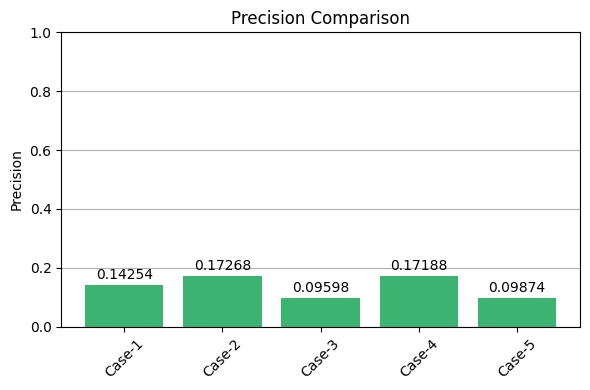

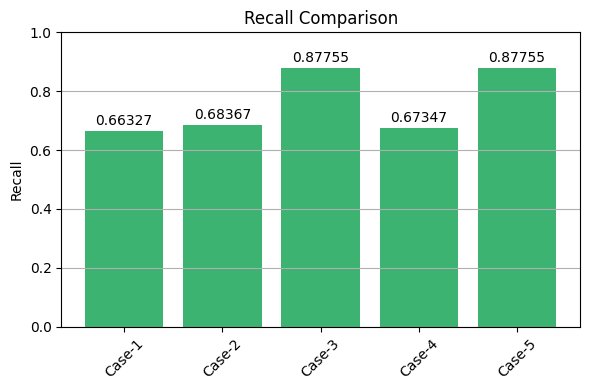

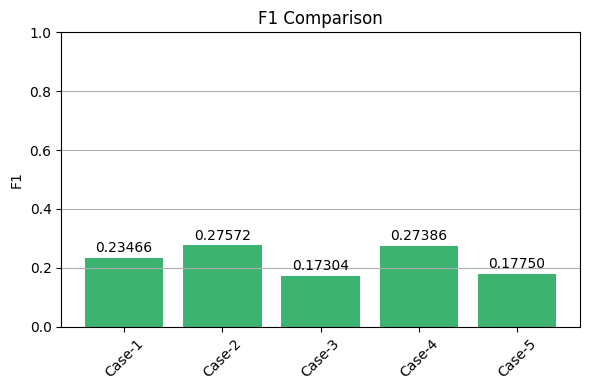

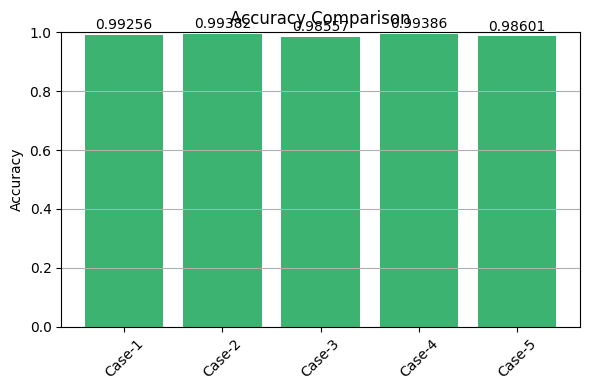

In [ ]:
metrics = ["precision", "recall",  "f1", "accuracy"]

# case 리스트
cases = list(scores.keys())

# metric별 값 정리
values_by_metric = {metric: [scores[case][metric] for case in cases] for metric in metrics}

# 그래프 그리기
for metric in metrics:
    plt.figure(figsize=(6, 4))

    bars = plt.bar(cases, values_by_metric[metric], color='mediumseagreen')

    plt.ylim(0, 1)
    plt.title(f"{metric.capitalize()} Comparison")
    plt.ylabel(metric.capitalize())
    plt.xticks(rotation=45)

    # 막대 위에 값 표시
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.5f}", ha='center', va='bottom')

    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

In [ ]:
# 먼저 Naive Bayes 모델을 이용하여 V1~V28 변수에 대한 변수 별 평균과 분산을 계산하였습니다.
# 이후, 이 값을 바탕으로 Separation Score를 산출하였고, 기준값 0.4 이하인 성분들은 구분력이 낮다고 판단하여 제거 대상으로 선정하였습니다.
#('V19','V21','V20','V8','V27','V13','V15','V24','V28','V23','V26','V22','V25') 총 13개
# 다음과 같이 5개의 Case로 나누어 실험을 진행하였습니다:
# 1) 어떤 변수도 제거하지 않은 경우
# 2) Separation Score가 낮은 13개의 PCA 성분만 제거한 경우
# 3) 13개의 PCA 성분 + Time 변수를 제거한 경우
# 4) 13개의 PCA 성분 + Amount 변수를 제거한 경우
# 5) 13개의 PCA 성분 + Time + Amount 변수를 모두 제거한 경우
# 각 Case에 대해 Naive Bayes 모델을 적용하고, Recall, Precision, F1-score, Accuracy, ROC AUC 지표를 산출하였습니다.

In [ ]:
# First, the Naive Bayes model was used to calculate the class-wise mean and variance for each of the V1–V28 features.
# Based on these values, Separation Scores were computed, and features with scores below the threshold of 0.4 were identified as having low discriminative power and selected for removal.
# A total of 13 features were selected: ('V19', 'V21', 'V20', 'V8', 'V27', 'V13', 'V15', 'V24', 'V28', 'V23', 'V26', 'V22', 'V25')
# The following five experimental cases were considered:
# 1) No features removed
# 2) Only the 13 low-scoring PCA components removed
# 3) The 13 PCA components and the Time variable removed
# 4) The 13 PCA components and the Amount variable removed
# 5) The 13 PCA components, Time, and Amount variables all removed
# For each case, a Naive Bayes model was applied, and performance was evaluated using Recall, Precision, F1-score, Accuracy, and ROC AUC.